In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')


In [4]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
data =  np.array(train_data)
submission_data = np.array(test_data)
m, n = data.shape

np.random.shuffle(data)

In [6]:
data_test = data[0:1000].T
X_test = data_test[1:n]
Y_test = data_test[0]
X_test = X_test / 255. # normalisation

data_train = data[1000:m].T
X_train = data_train[1:n]
Y_train = data_train[0]
X_train = X_train / 255. # normalisation

submission_data = (submission_data / 255.)
submission_data = submission_data.T

- The input layer has 784 entries, corresponding to the size of the input image (28x28 pixels).
- The hidden layer contains 10 units with ReLU activation.
- Finally, the output layer consists of 10 units, representing the 10 digits to predict, with a softmax activation.

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = {\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = {\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

**Vars and shapes**

Forward prop

- $A^{[0]} = X$: 784 x m
- $Z^{[1]} \sim A^{[1]}$: 10 x m
- $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
- $B^{[1]}$: 10 x 1
- $Z^{[2]} \sim A^{[2]}$: 10 x m
- $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
- $B^{[2]}$: 10 x 1

Backprop

- $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
- $dW^{[2]}$: 10 x 10
- $dB^{[2]}$: 10 x 1
- $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
- $dW^{[1]}$: 10 x 10
- $dB^{[1]}$: 10 x 1

In [7]:
# functions
def init_params(input_size, hidden_size, output_size):
    W1 = np.random.randn(hidden_size, input_size) * np.sqrt(2 / input_size)
    b1 = np.zeros((hidden_size, 1))
    W2 = np.random.randn(output_size, hidden_size) * np.sqrt(2 / hidden_size)
    b2 = np.zeros((output_size, 1))
    return W1, W2, b1, b2

def ReLU(z):
    return np.maximum(0, z)

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A


def forward_prop(W1, W2, b1, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def deriv_ReLU(z):
    return z > 0

def back_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    # m = Y.size
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * deriv_ReLU(Z1)
    dW1 = 1/ m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    W2 = W2 - alpha * dW2
    b1 = b1 - alpha * db1
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, iterations, alpha):
    W1, W2, b1, b2 = init_params(784, 10, 10)
    for i in range(0, iterations+1):
        Z1,A1, Z2, A2 = forward_prop(W1, W2, b1, b2, X)
        dW1, db1, dW2, db2 = back_prop(Z1,A1, Z2, A2, W1, W2, X, Y)
        W1, b1,W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 100 == 0:
            print(f"Iteration: {i}")
            print(f"Accuracy: {get_accuracy(get_predictions(A2), Y)}")

    return W1, b1, W2, b2

def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, W2, b1, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

In [8]:
# train the model here
epoch = 1000
lr = 0.01
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, epoch, lr)

Iteration: 0
Accuracy: 0.1384878048780488
Iteration: 100
Accuracy: 0.4603170731707317
Iteration: 200
Accuracy: 0.5832926829268292
Iteration: 300
Accuracy: 0.7079512195121951
Iteration: 400
Accuracy: 0.7673658536585366
Iteration: 500
Accuracy: 0.7938048780487805
Iteration: 600
Accuracy: 0.8113414634146342
Iteration: 700
Accuracy: 0.8244146341463414
Iteration: 800
Accuracy: 0.8326585365853658
Iteration: 900
Accuracy: 0.8396585365853658
Iteration: 1000
Accuracy: 0.8453658536585366


Prediction:  [5]
Label:  5


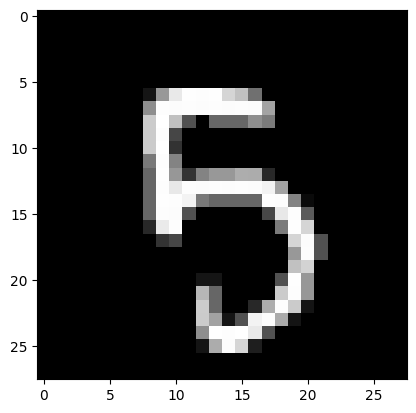

Prediction:  [7]
Label:  7


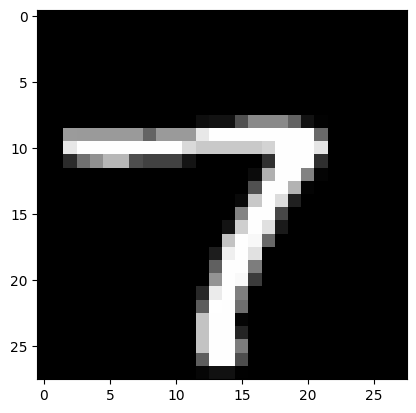

Prediction:  [9]
Label:  9


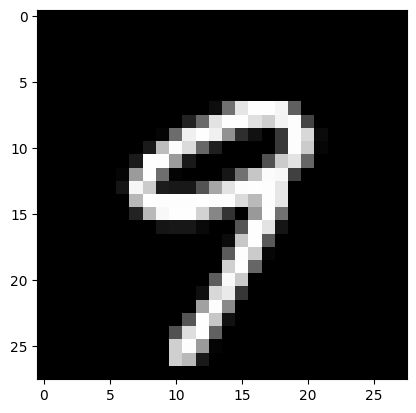

Prediction:  [0]
Label:  0


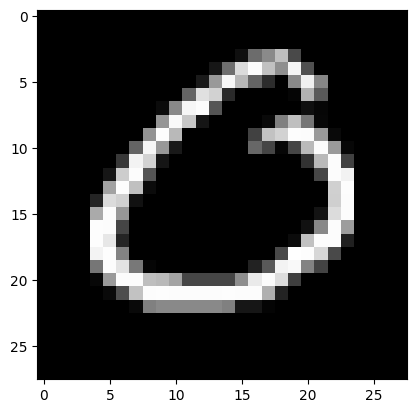

In [9]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [10]:
test_predictions = make_predictions(X_test, W1, b1, W2, b2)
get_accuracy(test_predictions, Y_test)

0.843

In [11]:
X_test.shape, test_predictions.shape

((784, 1000), (1000,))

In [12]:
s_m, s_n = submission_data.shape
imageIndex = [i+1 for i in range(0, s_n)]
imageIndex = np.array(imageIndex)

In [13]:
submission_pred = make_predictions(submission_data, W1, b1, W2, b2)

submission_df = pd.DataFrame({
    "ImageId": imageIndex,
    "Label": submission_pred
})

In [14]:
submission_df = submission_df.reset_index(drop=True)
submission_df.to_csv("submission.csv", index=False)

In [15]:
import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/working/submission.csv
/kaggle/working/__notebook__.ipynb
